# Attack MobileNet with 2 Project Gradient Descent Attacks Using AdverTorch

In [0]:
!pip install advertorch

In [0]:
#Note: Much of this code was adapted from https://bit.ly/2yZp8CC

# Import dependencies 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import pretrained model
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

# Import attacks
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks import L2PGDAttack

# Import attack utilities 
from advertorch.utils import predict_from_logits, NormalizeByChannelMeanStd
from advertorch_examples.utils import ImageNetClassNameLookup
from advertorch_examples.utils import get_panda_image 
from advertorch_examples.utils import bhwc2bchw # tensor shape conversion function
from advertorch_examples.utils import bchw2bhwc # tensor shape conversion function

In [0]:
# Define helper functions for understanding attack results

def tensor2npimg(tensor):
    """Convert tensor into a numpy image
    
    Parameters:
    tensor (tensor)

    Returns:
    bchw2bhwc(tensor[0].cpu().numpy()) (numpy array)
    
    """
    return bchw2bhwc(tensor[0].cpu().numpy())

def _show_images(enhance=50):
    """Display original image, perturbation, and perturbed image
    
    Parameters: 
    enhance (int) 

    Note: Perturbations need to be enhanced to be visible to the human eyy
    """

    # Convert tensor into numpy images
    np_advimg = tensor2npimg(advimg)
    np_perturb = tensor2npimg(advimg - img)

    # Obtain prediction and adversarial predictions on ImageNet images
    pred = imagenet_label2classname(predict_from_logits(model(img)))
    advpred = imagenet_label2classname(predict_from_logits(model(advimg)))

    # Display original image
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(np_img)
    plt.axis("off")
    plt.title("Original Image\n Prediction: {}".format(pred))
    
    # Display attack-developed perturbation as image
    plt.subplot(1, 3, 2)
    plt.imshow(np_perturb * enhance + 0.5)
    plt.axis("off")
    plt.title("Perturbation,\n Enhanced {} times".format(enhance))

    # Display original image with the perturbation
    plt.subplot(1, 3, 3)
    plt.imshow(np_advimg)
    plt.axis("off")
    plt.title("Perturbed Image\n Prediction: {}".format(advpred))
    plt.show()

In [0]:
# Set device as cuda for it to use the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Normalize the images
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

normalize = NormalizeByChannelMeanStd(
    mean=norm_mean, std=norm_std)

In [0]:
# Obtain pretrained MobileNet with normalized images
model = mobilenet_v2(pretrained=True)
model = nn.Sequential(normalize, model)
model = model.to(device)

In [0]:
# Establish panda image and label
np_img = get_panda_image()
img = torch.tensor(bhwc2bchw(np_img))[None, :, :, :].float().to(device)
label = torch.tensor([388, ]).long().to(device)
imagenet_label2classname = ImageNetClassNameLookup() # different classes for predictions

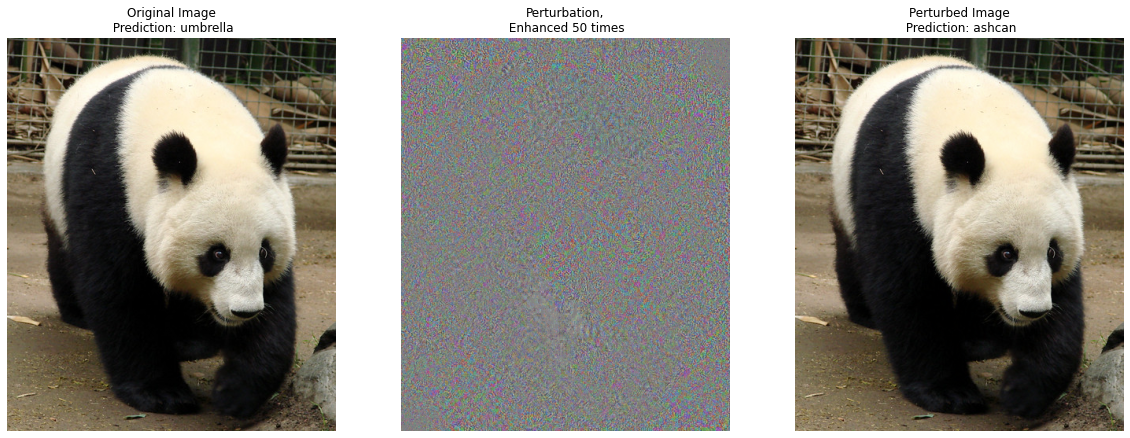

In [0]:
# Run and display results of a projected gradient descent attack
adversary = LinfPGDAttack(
    model, eps=1./255, eps_iter=1./255*2/40, nb_iter=40,
    rand_init=False, targeted=False)
advimg = adversary.perturb(img, label)
_show_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


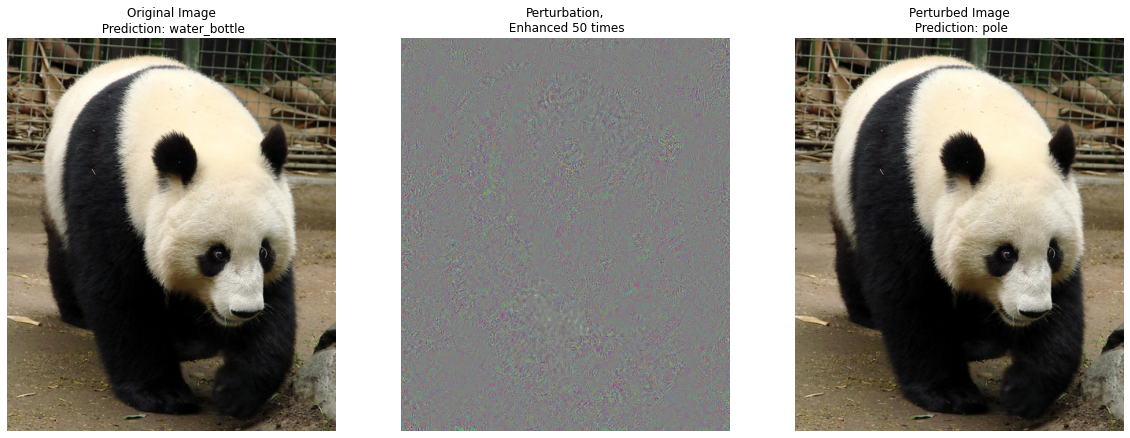

In [0]:
# Run and display results of another projected gradient descent attack
adversary = L2PGDAttack(
    model, eps=1., eps_iter=1.*2/40, nb_iter=40,
    rand_init=False, targeted=False)
advimg = adversary.perturb(img, label)
_show_images()